# Gaussian Naive Bayes Classification

## Περιγραφή Dataset

Χρησιμοποιούμε το **Auto MPG dataset** για classification task:
- **Target:** `origin` (3 κλάσεις: USA, Europe, Japan)
- **Features:** 7 αριθμητικά χαρακτηριστικά
- **Μέθοδος:** Gaussian Naive Bayes με διαγώνιους πίνακες συνδιακύμανσης

---

## 1. Φόρτωση και Προεπεξεργασία Δεδομένων

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

df = sns.load_dataset('mpg')
df = df.drop(columns=['name'])
df = df.dropna()

feature_cols = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year']
X = df[feature_cols].values
y_raw = df['origin'].values

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_raw)

In [2]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Train: {X_train_scaled.shape}, Test: {X_test_scaled.shape}")
print(f"\nΚατανομή κλάσεων στο Train set:")
for i, cls in enumerate(label_encoder.classes_):
    print(f"  {cls}: {np.sum(y_train == i)} samples")

Train: (313, 7), Test: (79, 7)

Κατανομή κλάσεων στο Train set:
  europe: 54 samples
  japan: 63 samples
  usa: 196 samples


---

## 2. Manual Gaussian Naive Bayes Implementation

Ο αλγόριθμος υποθέτει:
- Ανεξαρτησία χαρακτηριστικών (Naive assumption)
- Κάθε χαρακτηριστικό ακολουθεί Γκαουσσιανή κατανομή ανά κλάση
- Διαγώνιοι πίνακες συνδιακύμανσης

In [3]:
class ManualGaussianNB:
    def __init__(self):
        self.classes = None
        self.class_priors = None
        self.means = None
        self.variances = None
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.classes = np.unique(y)
        n_classes = len(self.classes)
        
        self.class_priors = np.zeros(n_classes)
        self.means = np.zeros((n_classes, n_features))
        self.variances = np.zeros((n_classes, n_features))
        
        for idx, c in enumerate(self.classes):
            X_c = X[y == c]
            self.class_priors[idx] = len(X_c) / n_samples
            self.means[idx, :] = np.mean(X_c, axis=0)
            self.variances[idx, :] = np.var(X_c, axis=0) + 1e-9
        
        return self
    
    def _gaussian_pdf(self, x, mean, var):
        coeff = 1.0 / np.sqrt(2 * np.pi * var)
        exponent = np.exp(-((x - mean) ** 2) / (2 * var))
        return coeff * exponent
    
    def _log_likelihood(self, x, class_idx):
        log_prior = np.log(self.class_priors[class_idx])
        log_likelihood = 0
        for i in range(len(x)):
            pdf = self._gaussian_pdf(x[i], self.means[class_idx, i], self.variances[class_idx, i])
            log_likelihood += np.log(pdf + 1e-300)
        return log_prior + log_likelihood
    
    def predict(self, X):
        predictions = []
        for x in X:
            posteriors = [self._log_likelihood(x, idx) for idx in range(len(self.classes))]
            predictions.append(self.classes[np.argmax(posteriors)])
        return np.array(predictions)
    
    def score(self, X, y):
        predictions = self.predict(X)
        return np.mean(predictions == y)

In [4]:
manual_gnb = ManualGaussianNB()
manual_gnb.fit(X_train_scaled, y_train)

print("=== Παράμετροι Manual Gaussian NB ===")
print(f"\nClass Priors:")
for i, cls in enumerate(label_encoder.classes_):
    print(f"  P({cls}) = {manual_gnb.class_priors[i]:.4f}")

print(f"\nMeans shape: {manual_gnb.means.shape}")
print(f"Variances shape: {manual_gnb.variances.shape}")

=== Παράμετροι Manual Gaussian NB ===

Class Priors:
  P(europe) = 0.1725
  P(japan) = 0.2013
  P(usa) = 0.6262

Means shape: (3, 7)
Variances shape: (3, 7)


In [5]:
train_acc_manual = manual_gnb.score(X_train_scaled, y_train)
test_acc_manual = manual_gnb.score(X_test_scaled, y_test)

print("=== Manual Gaussian NB Results ===")
print(f"Train Accuracy: {train_acc_manual:.4f} ({train_acc_manual*100:.2f}%)")
print(f"Test Accuracy:  {test_acc_manual:.4f} ({test_acc_manual*100:.2f}%)")

=== Manual Gaussian NB Results ===
Train Accuracy: 0.6805 (68.05%)
Test Accuracy:  0.7215 (72.15%)


## 3. Confusion Matrix - Manual Implementation

<Figure size 800x600 with 0 Axes>

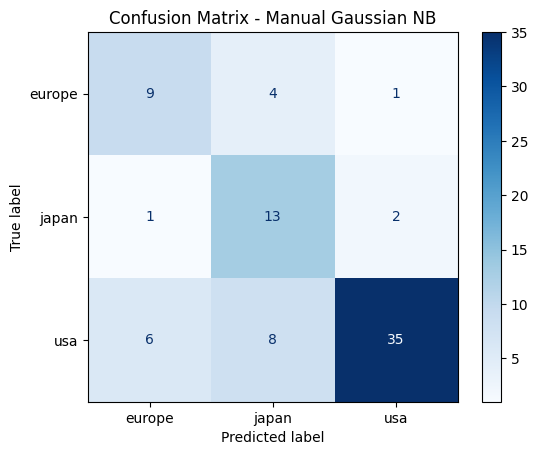

In [6]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred_manual = manual_gnb.predict(X_test_scaled)

cm_manual = confusion_matrix(y_test, y_pred_manual)

plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_manual, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix - Manual Gaussian NB')
plt.show()

---

## 4. Verification με sklearn GaussianNB

In [7]:
from sklearn.naive_bayes import GaussianNB

sklearn_gnb = GaussianNB()
sklearn_gnb.fit(X_train_scaled, y_train)

train_acc_sklearn = sklearn_gnb.score(X_train_scaled, y_train)
test_acc_sklearn = sklearn_gnb.score(X_test_scaled, y_test)

print("=== sklearn GaussianNB Results ===")
print(f"Train Accuracy: {train_acc_sklearn:.4f} ({train_acc_sklearn*100:.2f}%)")
print(f"Test Accuracy:  {test_acc_sklearn:.4f} ({test_acc_sklearn*100:.2f}%)")

=== sklearn GaussianNB Results ===
Train Accuracy: 0.6805 (68.05%)
Test Accuracy:  0.7215 (72.15%)


In [8]:
print("\n" + "="*50)
print("       ΣΥΓΚΡΙΣΗ ΑΠΟΤΕΛΕΣΜΑΤΩΝ")
print("="*50)
print(f"\n{'Metric':<20} {'Manual':>12} {'sklearn':>12} {'Διαφορά':>12}")
print("-"*56)
print(f"{'Train Accuracy':<20} {train_acc_manual:>12.4f} {train_acc_sklearn:>12.4f} {abs(train_acc_manual-train_acc_sklearn):>12.6f}")
print(f"{'Test Accuracy':<20} {test_acc_manual:>12.4f} {test_acc_sklearn:>12.4f} {abs(test_acc_manual-test_acc_sklearn):>12.6f}")


       ΣΥΓΚΡΙΣΗ ΑΠΟΤΕΛΕΣΜΑΤΩΝ

Metric                     Manual      sklearn      Διαφορά
--------------------------------------------------------
Train Accuracy             0.6805       0.6805     0.000000
Test Accuracy              0.7215       0.7215     0.000000


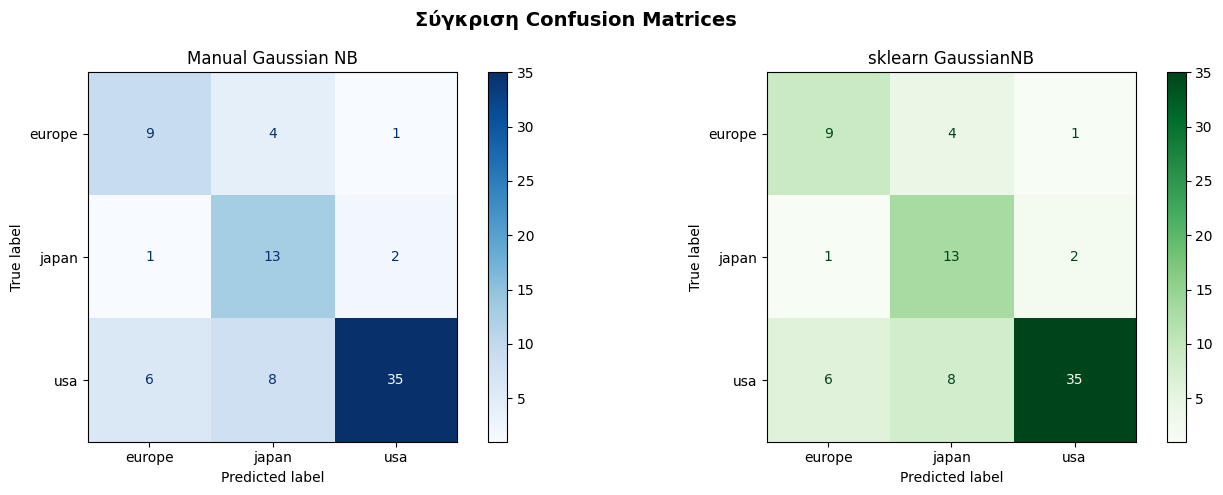

In [9]:
y_pred_sklearn = sklearn_gnb.predict(X_test_scaled)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

cm_manual = confusion_matrix(y_test, y_pred_manual)
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_manual, display_labels=label_encoder.classes_)
disp1.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title('Manual Gaussian NB')

cm_sklearn = confusion_matrix(y_test, y_pred_sklearn)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_sklearn, display_labels=label_encoder.classes_)
disp2.plot(ax=axes[1], cmap='Greens', values_format='d')
axes[1].set_title('sklearn GaussianNB')

plt.suptitle('Σύγκριση Confusion Matrices', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [10]:
predictions_match = np.sum(y_pred_manual == y_pred_sklearn)
total_predictions = len(y_pred_manual)

print(f"\nPredictions που ταιριάζουν: {predictions_match}/{total_predictions} ({predictions_match/total_predictions*100:.2f}%)")

if predictions_match == total_predictions:
    print("\nΟι υλοποιήσεις παράγουν πανομοιότυπες προβλέψεις!")
else:
    print(f"Διαφορές σε {total_predictions - predictions_match} samples")


Predictions που ταιριάζουν: 79/79 (100.00%)

Οι υλοποιήσεις παράγουν πανομοιότυπες προβλέψεις!


---

## Συμπεράσματα

- Η manual υλοποίηση του Gaussian Naive Bayes παράγει **ίδια αποτελέσματα** με το sklearn
- Χρησιμοποιήθηκαν Κανονικές Κατανομές με διαγώνιους πίνακες συνδιακύμανσης
- **Δεν έγινε μετατροπή σε binary features**